# Processing of Big Data - creating using gaussian distribution from file 30_large swap file

## Featurization function 

In [10]:
from ase.io import read,write
import pymatgen
from pymatgen.analysis.local_env import VoronoiNN
from scipy.spatial import Voronoi, SphericalVoronoi
from pymatgen.io.ase import AseAtomsAdaptor
import os
import pickle
import uuid
import json
from collections import OrderedDict, Iterable, Mapping
from multiprocess import Pool
import numpy as np
import gc
import tqdm
import ase.io
from ase import Atoms
from ase.constraints import FixAtoms
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.local_env import VoronoiNN
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
import numpy as np
from numpy import genfromtxt
from os import listdir
import time 
import pandas as pd
import random
import torch
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from torch.autograd import Variable

def fingerprint_atoms_2(atoms):
    '''
    This function is used to fingerprint an adslabs atoms object, where the "fingerprint" is a
    dictionary of properties that we believe may be adsorption motifs.
    Inputs:
        atoms   Atoms object to fingerprint. The slab atoms must be tagged with 0 and
                adsorbate atoms must be tagged with non-zero integers. This function also
                assumes that the first atom in each adsorbate is the binding atom (e.g.,
                of all atoms with tag==1, the first atom is the binding; the same goes for
                tag==2 and tag==3 etc.).
    '''
#     # Remove the adsorbate(s) while finding the binding position(s)
#     atoms, binding_positions = remove_adsorbate(atoms)
#     # Add Uranium atoms at each of the binding sites so that we can use them for fingerprinting.
#     for tag in binding_positions:
#         atoms += Atoms('U', positions=[binding_positions[tag]])

    # Turn the atoms into a pymatgen structure object so that we can use the VCF to find
    # the coordinated sites.
    struct = AseAtomsAdaptor.get_structure(atoms)

    #Test to see if the central atom is entirely on it's own, if so it is not coordinated, so skip the voronoi bit
    # which would throw a QHULL error
    num_cutoff_neighbors = [site[0] for site in enumerate(struct) if 0.1 < struct[len(atoms)-1].distance(site[1]) < 7.0]
    if len(num_cutoff_neighbors) == 0:
        return {'coordination': '',
                'neighborcoord': '',
                'natoms': len(atoms),
                'nextnearestcoordination': ''}

    vnn = VoronoiNN(allow_pathological=True, tol=0.8, cutoff=10)
    vnn_loose = VoronoiNN(allow_pathological=True, tol=0.2, cutoff=10)
    try:
        coordinated_atoms_data = vnn.get_nn_info(struct, len(atoms)-1)
    except ValueError:
        vnn = VoronoiNN(allow_pathological=True, tol=0.8, cutoff=40)
        vnn_loose = VoronoiNN(allow_pathological=True, tol=0.2, cutoff=40)
        coordinated_atoms_data = vnn.get_nn_info(struct, len(atoms)-1)
    coordinated_atoms = [atom_data['site'] for atom_data in coordinated_atoms_data]
    # Create a list of symbols of the coordinations, remove uranium from the list, and
    # then turn the list into a single, human-readable string.
    coordinated_symbols = map(lambda x: x.species_string, coordinated_atoms)
    coordinated_symbols = [a for a in coordinated_symbols if a not in ['U']]
    coordination = '-'.join(sorted(coordinated_symbols))

    # Make a [list] of human-readable coordination sites [unicode] for all of the slab atoms
    # that are coordinated to the adsorbate, "neighborcoord"
    neighborcoord = []
    for i in coordinated_atoms:
        # [int] that yields the slab+ads system's atomic index for the 1st-tier-coordinated atom
        neighborind = [site[0] for site in enumerate(struct) if i.distance(site[1]) < 0.1][0]
        # [list] of PyMatGen [periodic site class]es for each of the atoms that are coordinated
        # with the adsorbate
        coord_data = vnn_loose.get_nn_info(struct, neighborind)
        coord = [atom_data['site'] for atom_data in coord_data]
        # The elemental symbols for all of the 2nd-tier-coordinated atoms in a [list] of
        # [unicode] objects
        coord_symbols = map(lambda x: x.species_string, coord)
        # Take out atoms that we assume are not part of the slab
        coord_symbols = [a for a in coord_symbols if a not in ['U']]
        # Sort the list of 2nd-tier-coordinated atoms to induce consistency
        coord_symbols.sort()
        # Turn the [list] of [unicode] values into a single [unicode]
        neighborcoord.append(i.species_string+':'+'-'.join(coord_symbols))

    # [list] of PyMatGen [periodic site class]es for each of the atoms that are
    # coordinated with the adsorbate
    coordinated_atoms_nextnearest_data = vnn_loose.get_nn_info(struct, len(atoms)-1)
    coordinated_atoms_nextnearest = [atom_data['site'] for atom_data in coordinated_atoms_nextnearest_data]
    # The elemental symbols for all of the coordinated atoms in a [list] of [unicode] objects
    coordinated_symbols_nextnearest = map(lambda x: x.species_string,
                                          coordinated_atoms_nextnearest)
    # Take out atoms that we assume are not part of the slab
    coordinated_symbols_nextnearest = [a for a in coordinated_symbols_nextnearest
                                       if a not in ['U']]
    # Turn the [list] of [unicode] values into a single [unicode]
    coordination_nextnearest = '-'.join(sorted(coordinated_symbols_nextnearest))

    # Return a dictionary with each of the fingerprints. Any key/value pair can be added here
    # and will propagate up the chain
    return {'coordination': coordination,
            'neighborcoord': neighborcoord,
            'natoms': len(atoms),
            'nextnearestcoordination': coordination_nextnearest}

def nearest_neighbor_count(neighbors,atom_type):
#Takes neighbors as a dictionary object and the atom type whose coordination number
#we are interested in 
#The neighbor object is within a cut off radius of 7 Angstrom
    C=neighbors['coordination']    
    return C.count(atom_type)

def next_nearest_neighbor_count(neighbors,atom_type):
#Takes neighbors as a dictionary object and the atom type whose coordination number
#we are interested in 
#The neighbor object is within a cut off radius of 7 Angstrom
    N=neighbors['neighborcoord']
    NN=neighbors['nextnearestcoordination']
    N_count=0
    for i in range(len(N)):
        s=N[i]
        sub_s=s[s.index(':') + len(':'):]
        N_count+=sub_s.count(atom_type)
    return N_count

# Create Gaussian distributions and write to xlsx
def ret_Gaussian(mu,sigma,N):
    s = np.random.normal(mu, sigma, N)
    return s


def featurize_new(atoms):
    a=fingerprint_atoms_2(atoms)
    C=a['coordination']
    N=a['neighborcoord']
    NN=a['nextnearestcoordination']
    neighbor_types=['S','Co', 'Ti', 'Cu', 'Mn', 'Mo', 'V', 'Ru', 'Sc']
    atom_number=np.array([16,27,22,29,25,42,23,44,21])
    chi=np.array([2.58,1.88,1.54,1.92,1.90,1.55,2.16,1.63,2.2,1.36])

    std_GOH = np.array([0.17,0.19,0.16,0.20,0.21,0.21,0.15,0.12,0.13])
    feature_vec=np.zeros((3,2*len(neighbor_types)))
    for i in range(len(neighbor_types)):
        if nearest_neighbor_count(a,neighbor_types[i])!=0:
            feature_vec[:,i]=(np.array([atom_number[i],chi[i],nearest_neighbor_count(a,neighbor_types[i])])).T
        else:
            feature_vec[:,i]=(np.array([0,0,0])).T
    for i in range(len(neighbor_types)):
        if next_nearest_neighbor_count(a,neighbor_types[i])!=0:
            feature_vec[:,i+len(neighbor_types)]=(np.array([atom_number[i],chi[i],next_nearest_neighbor_count(a,neighbor_types[i])])).T
        else:
            feature_vec[:,i+len(neighbor_types)]=(np.array([0,0,0])).T

    return feature_vec


## Loading big data saved in location 

In [11]:
## Big Data
## Fetching DGOH data all sulfide classes

import numpy as np
from numpy import genfromtxt
from os import listdir
import time 
import pandas as pd
import random
import torch
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from torch.autograd import Variable
comp = ['CoS','CuS','MnS','MoS','RuS','ScS','TiS','VS']


####################################################
#loading all file names 
def find_xyz_filenames( path_to_dir, suffix=".xyz" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

path='newdata_complete'
CoS_filenames = find_xyz_filenames(path+'/CoS')
CuS_filenames = find_xyz_filenames(path+'/CuS')
MnS_filenames = find_xyz_filenames(path+'/MnS')
MoS_filenames = find_xyz_filenames(path+'/MoS')
RuS_filenames = find_xyz_filenames(path+'/RuS')
ScS_filenames = find_xyz_filenames(path+'/ScS')
TiS_filenames = find_xyz_filenames(path+'/TiS')
VS_filenames = find_xyz_filenames(path+'/VS')


#####################################################
#loading the excel file
def find_xlsx_filenames( path_to_dir, suffix=".xlsx" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

xlsx_filenames = find_xlsx_filenames('data')



######################################################
#loading xlsx data
path ='data/'+xlsx_filenames[0]

##reading the data from each sheet
df = pd.read_excel(path,sheet_name=0)
delta_g_CoS = df[df.columns[0]]
ads_CoS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=1)
delta_g_CuS = df[df.columns[0]]
ads_CuS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=2)
delta_g_MnS = df[df.columns[0]]
ads_MnS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=3)
delta_g_TiS = df[df.columns[0]]
ads_TiS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=4)
delta_g_RuS = df[df.columns[0]]
ads_RuS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=5)
delta_g_MoS = df[df.columns[0]]
ads_MoS = df[df.columns[1]]

df = pd.read_excel(path,sheet_name=6)
delta_g_ScS = df[df.columns[0]]
ads_ScS = df[df.columns[1]]


df = pd.read_excel(path,sheet_name=7)
delta_g_VS = df[df.columns[0]]
ads_VS = df[df.columns[1]]

std_GOH = np.array([0.17,0.19,0.16,0.20,0.21,0.21,0.15,0.12,0.13])

N=30
j=0
vec_Co=np.zeros((len(delta_g_CoS),N))
for i in range(len(delta_g_CoS)):
    vec_Co[i,:]=(ret_Gaussian(delta_g_CoS[i],std_GOH[j],N)).T
j=j+1

vec_Cu=np.zeros((len(delta_g_CuS),N))
for i in range(len(delta_g_CuS)):
    vec_Cu[i,:]=ret_Gaussian(delta_g_CuS[i],std_GOH[j],N)
j=j+1

vec_Mn=np.zeros((len(delta_g_MnS),N))
for i in range(len(delta_g_MnS)):
    vec_Mn[i,:]=ret_Gaussian(delta_g_MnS[i],std_GOH[j],N)
j=j+1

vec_Ti=np.zeros((len(delta_g_TiS),N))
for i in range(len(delta_g_TiS)):
    vec_Ti[i,:]=ret_Gaussian(delta_g_TiS[i],std_GOH[j],N)
j=j+1

vec_Ru=np.zeros((len(delta_g_RuS),N))
for i in range(len(delta_g_RuS)):
    vec_Ru[i,:]=ret_Gaussian(delta_g_RuS[i],std_GOH[j],N)
j=j+1

vec_Mo=np.zeros((len(delta_g_MoS),N))
for i in range(len(delta_g_MoS)):
    vec_Mo[i,:]=ret_Gaussian(delta_g_MoS[i],std_GOH[j],N)
j=j+1

vec_Sc=np.zeros((len(delta_g_ScS),N))
for i in range(len(delta_g_ScS)):
    vec_Sc[i,:]=ret_Gaussian(delta_g_ScS[i],std_GOH[j],N)
j=j+1

vec_V=np.zeros((len(delta_g_VS),N))
for i in range(len(delta_g_VS)):
    vec_V[i,:]=ret_Gaussian(delta_g_VS[i],std_GOH[j],N)
j=j+1

vec_Co_reshape=np.reshape(vec_Co.T,(vec_Co.T.size,1))
vec_Cu_reshape=np.reshape(vec_Cu.T,(vec_Cu.T.size,1))
vec_Mn_reshape=np.reshape(vec_Mn.T,(vec_Mn.T.size,1))
vec_Ti_reshape=np.reshape(vec_Ti.T,(vec_Ti.T.size,1))
vec_Ru_reshape=np.reshape(vec_Ru.T,(vec_Ru.T.size,1))
vec_Mo_reshape=np.reshape(vec_Mo.T,(vec_Mo.T.size,1))
vec_Sc_reshape=np.reshape(vec_Sc.T,(vec_Sc.T.size,1))
vec_V_reshape=np.reshape(vec_V.T,(vec_V.T.size,1))
                         
                          
DGOH=np.hstack((vec_Co_reshape.T,vec_Cu_reshape.T,vec_Mn_reshape.T,vec_Ti_reshape.T,vec_Ru_reshape.T,vec_Mo_reshape.T,vec_Sc_reshape.T,vec_V_reshape.T))
print(DGOH.shape)


(1, 1470)


## Create of feature matrix using the input data

In [12]:
## Building feature vector from all sulfides


def fetchdata(filenames,stringname,size):
    neighbor_types=['S','Co', 'Cr', 'Cu', 'Mn', 'Mo', 'V', 'Ru', 'Sc']
    featureVectorStack=np.zeros((3,2*len(neighbor_types),size))
    path='newdata_complete'
    r = 0
    for i in range(0,len(filenames)):
        atoms=read(path+'/'+stringname+'/'+str(i)+'.xyz')
        featureVectorStack[:,:,i]=featurize_new(atoms)
    return featureVectorStack
        
       
FV1=fetchdata(CoS_filenames,'CoS',len(delta_g_CoS)*N)  
print('Co done')
FV2=fetchdata(CuS_filenames,'CuS',len(delta_g_CuS)*N)  
print('Cu done')
FV3=fetchdata(MnS_filenames,'MnS',len(delta_g_MnS)*N)  
print('Mn done')
FV4=fetchdata(TiS_filenames,'TiS',len(delta_g_TiS)*N)
print('Ti done')
FV5=fetchdata(RuS_filenames,'RuS',len(delta_g_RuS)*N)  
print('Ru done')
FV6=fetchdata(MoS_filenames,'MoS',len(delta_g_MoS)*N)  
print('Mo done')
FV7=fetchdata(ScS_filenames,'ScS',len(delta_g_ScS)*N)  
print('Sc done')
FV8=fetchdata(VS_filenames,'VS',len(delta_g_VS)*N)  
print('V done')
FV=np.dstack((FV1,FV2,FV3,FV4,FV5,FV6,FV7,FV8))



Co done
Cu done
Mn done
Ti done
Ru done
Mo done
Sc done
V done


In [45]:
# print (FV1)
# print (FV2)
# print (FV3)
# print (FV4)
# print (FV5)
# print (FV6)
# print (FV7)
# print (FV8)
FV=np.dstack((FV1,FV2,FV3,FV4,FV5,FV6,FV7,FV8))
print ('\n')
print (FV)

import numpy as np


file.write(FV_shape) 


print(FV.shape)

a=np.array([[1,2,3],[4,5,6]])
b=np.reshape(a,(a.size,1))
print(b)
c=np.reshape(a.T,(a.size,1))
print(c)




[[[16.   16.    0.   ...  0.    0.    0.  ]
  [ 0.    0.   27.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  ...
  [ 0.    0.    0.   ... 23.   23.   23.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]]

 [[ 2.58  2.58  0.   ...  0.    0.    0.  ]
  [ 0.    0.    1.88 ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  ...
  [ 0.    0.    0.   ...  2.16  2.16  2.16]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]]

 [[ 3.    4.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    4.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  ...
  [ 0.    0.    0.   ...  3.    3.    6.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]]]


NameError: name 'file' is not defined

In [47]:
print(len(CoS_filenames))

r,c,d=FV.shape
print (FV.shape)
FV_reshape = FV.reshape((r*c,d))

print (DGOH.T.shape)
print (FV)


210
(3, 18, 1470)
(1470, 1)
[[[16.   16.    0.   ...  0.    0.    0.  ]
  [ 0.    0.   27.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  ...
  [ 0.    0.    0.   ... 23.   23.   23.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]]

 [[ 2.58  2.58  0.   ...  0.    0.    0.  ]
  [ 0.    0.    1.88 ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  ...
  [ 0.    0.    0.   ...  2.16  2.16  2.16]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]]

 [[ 3.    4.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    4.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  ...
  [ 0.    0.    0.   ...  3.    3.    6.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]
  [ 0.    0.    0.   ...  0.    0.    0.  ]]]


In [48]:
# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(FV_reshape.T))
dg = np.array(DGOH.T)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)

print (x.shape)
print (y.shape)

#######neural network


# Defining input size, hidden layer size, output size and batch size respectively
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 54, 54,54,54, 1, 49



# Create a model
model = nn.Sequential(nn.Linear(n_in, n_h1),nn.Linear(n_h1, n_h2),nn.Linear(n_h2, n_h3),
                     nn.Linear(n_h3, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


torch.Size([1470, 54])
torch.Size([1470, 1])
epoch:  0  loss:  0.6845226883888245
epoch:  1000  loss:  0.07430923730134964
epoch:  2000  loss:  0.07291791588068008
epoch:  3000  loss:  0.07392314821481705
epoch:  4000  loss:  0.07289174199104309
epoch:  5000  loss:  0.0756450816988945
epoch:  6000  loss:  0.07290182262659073
epoch:  7000  loss:  0.0729731097817421
epoch:  8000  loss:  0.07291150093078613
epoch:  9000  loss:  0.07372139394283295


[[ 0.2562001 ]
 [ 0.2837971 ]
 [ 0.57345295]
 ...
 [-1.1825203 ]
 [-0.723073  ]
 [-1.225392  ]]
[[ 0.41596094]
 [ 0.23714057]
 [ 0.7845421 ]
 ...
 [-0.9482734 ]
 [-0.9482734 ]
 [-0.87507915]]
0.32328212


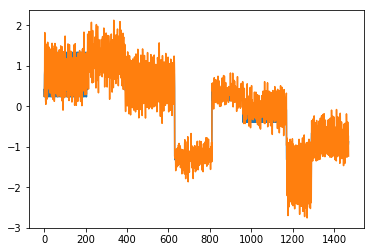

In [49]:


y1_pred = y_pred.detach().numpy()
y1  = y.detach().numpy()

print (y1)
print (y1_pred)

plt.plot(range(0,len(y1_pred)),y1_pred)
plt.plot(range(0,len(y1)),y1)
print (np.std(y1_pred-y1))

In [ ]:
print (optimizer.score)

In [ ]:
(optimizer.score(np.asmatrix(FV_reshape.T), DGOH))

In [ ]:
import sklearn.model_selection
from tpot import TPOTRegressor
from sklearn.metrics.scorer import make_scorer


############################
#parameter descriptions:
#generations = how many iterations to go through in optimizer
#population_size = number of individuals to retain in algrotihm every generation (will work better with more, but take longer)
#random_state = random seed going into optimizer. Should get the same result if we use the same data and seed
#changing seed may affect result
#verbosity = how much TPOT prints out while it's running, integer value 0-3. 0=prints nothing, 3=prints everything
###############################

# Make a custom metric function
def my_custom_accuracy(y_true, y_pred):
    return np.std(y_pred- y_true)

# Make a custom a scorer from the custom metric function
# Note: greater_is_better=False in make_scorer below would mean that the scoring function should be minimized.
my_custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=False)

# tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
#                       scoring=my_custom_scorer)



optimizer = TPOTRegressor(generations=20, population_size=20, random_state=99, verbosity=2,periodic_checkpoint_folder="tpot_results.txt" ,
                      scoring=my_custom_scorer)


print (FV_reshape.shape)
print (DGOH.shape)

#fit to training data
optimizer.fit(FV_reshape.T, DGOH.T)

In [ ]:
result = optimizer.predict(np.asmatrix(FV_reshape.T))

print (np.std(result-DGOH))

In [ ]:
#####with test train split

In [ ]:
print(len(CoS_filenames))

r,c,d=FV.shape


print (r)
print (FV.shape)
print(FV[2,:,:])
FV_reshape = FV.reshape((r*c,d))
print (FV_reshape.shape)

print (DGOH.T.shape)

In [ ]:
## TPOT implementation with train and test split 
### The standard deveation is calculcuated on Test Set 

In [ ]:
###with test train split
print(DGOH.shape)
print (FV_reshape.shape)

X_train, X_test, y_train, y_test = train_test_split(FV_reshape, DGOH.T, test_size=0.33, random_state=42,shuffle= True)




In [ ]:


import sklearn.model_selection
from tpot import TPOTRegressor
from sklearn.metrics.scorer import make_scorer


############################
#parameter descriptions:
#generations = how many iterations to go through in optimizer
#population_size = number of individuals to retain in algrotihm every generation (will work better with more, but take longer)
#random_state = random seed going into optimizer. Should get the same result if we use the same data and seed
#changing seed may affect result
#verbosity = how much TPOT prints out while it's running, integer value 0-3. 0=prints nothing, 3=prints everything
###############################

# Make a custom metric function
def my_custom_accuracy(y_true, y_pred):
    return np.std(y_pred- y_true)

# Make a custom a scorer from the custom metric function
# Note: greater_is_better=False in make_scorer below would mean that the scoring function should be minimized.
my_custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=False)

# tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
#                       scoring=my_custom_scorer)



optimizer = TPOTRegressor(generations=20, population_size=20, random_state=99, verbosity=2,periodic_checkpoint_folder="tpot_results.txt" ,
                      scoring=my_custom_scorer)

#fit to training data
optimizer.fit(X_train, y_train)


In [ ]:
result = optimizer.predict(X_test)

print (np.std(result-y_test))

In [ ]:
###Neural network with test train split

In [50]:
print(len(CoS_filenames))

r,c,d=FV.shape


print (r)
print (FV.shape)
print(FV[2,:,:])
FV_reshape = FV.reshape((r*c,d))
print (FV_reshape.shape)

print (DGOH.T.shape)

###with test train split

X_train, X_test, y_train, y_test = train_test_split(FV_reshape.T, DGOH.T, test_size=0.33, random_state=42,shuffle= True)

210
3
(3, 18, 1470)
[[3. 4. 0. ... 0. 0. 0.]
 [0. 0. 4. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 3. 3. 6.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(54, 1470)
(1470, 1)


In [51]:
# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(X_train))
dg = np.array(y_train)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)


#######neural network


# Defining input size, hidden layer size, output size and batch size respectively
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 54, 54,54,54, 1, 20



# Create a model
model = nn.Sequential(nn.Linear(n_in, n_h1),nn.Linear(n_h1, n_h2),
                     nn.Linear(n_h3, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


epoch:  0  loss:  3.3462882041931152
epoch:  1000  loss:  0.07373067736625671
epoch:  2000  loss:  0.07317058742046356
epoch:  3000  loss:  0.07326259464025497
epoch:  4000  loss:  0.07319285720586777
epoch:  5000  loss:  0.07680903375148773
epoch:  6000  loss:  0.0779695212841034
epoch:  7000  loss:  0.0732085257768631
epoch:  8000  loss:  0.0732807144522667
epoch:  9000  loss:  0.07341305911540985


0.27288500944335986


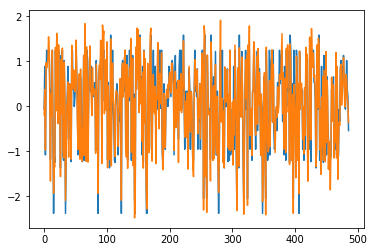

In [52]:
test_data = torch.FloatTensor(np.array(X_test))

x_test =  Variable(test_data)
y_pred_test = model(test_data)
y1_pred = y_pred_test.detach().numpy()
y1  = y_test

plt.plot(range(0,len(y1_pred)),y1_pred)
plt.plot(range(0,len(y1)),y1)
print (np.std(y1_pred-y1))

In [53]:
###########Using only coordination number 



r,c,d=FV.shape

print (FV[2,:,:])
FV_coordination = FV[2,:,:]
print (FV_coordination.shape)

###with test train split

X_train_co, X_test_co, y_train_co, y_test_co = train_test_split(FV_coordination.T, DGOH.T, test_size=0.3, random_state=42,shuffle=True)





[[3. 4. 0. ... 0. 0. 0.]
 [0. 0. 4. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 3. 3. 6.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(18, 1470)


In [54]:

# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(X_train_co))
dg = np.array(y_train_co)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)


#######neural network


# Defining input size, hidden layer size, output size and batch size respectively
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 18, 18,16,18, 1, 20



# Create a model
model = nn.Sequential(nn.Linear(n_in, n_h1),
                     nn.Linear(n_h3, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


epoch:  0  loss:  1.4661831855773926
epoch:  1000  loss:  0.23637755215168
epoch:  2000  loss:  0.23668769001960754
epoch:  3000  loss:  0.2363763153553009
epoch:  4000  loss:  0.2363763004541397
epoch:  5000  loss:  0.2363763004541397
epoch:  6000  loss:  0.2364157736301422
epoch:  7000  loss:  0.2363937348127365
epoch:  8000  loss:  0.2363763004541397
epoch:  9000  loss:  0.2363763451576233


0.4558893699135574


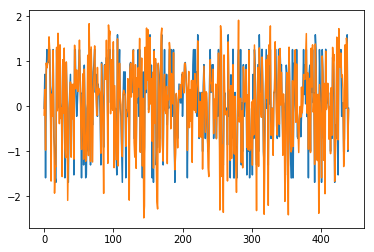

In [55]:
test_data = torch.FloatTensor(np.array(X_test_co))

x_test =  Variable(test_data)
y_pred_test = model(test_data)
y1_pred = y_pred_test.detach().numpy()
y1  = y_test_co

plt.plot(range(0,len(y1_pred)),y1_pred)
plt.plot(range(0,len(y1)),y1)
print (np.std(y1_pred-y1))

In [42]:
#######only one compound at a time CoS


###considering all the features



r,c,d=FV1.shape


FV1_reshape = FV1.reshape((r*c,d))

###with test train split

X_train_Cob, X_test_Cob, y_train_Cob, y_test_Cob = train_test_split(FV1_reshape.T, vec_Co_reshape, test_size=0.2, random_state=42,shuffle=True)


print (X_train_Cob.shape)

(168, 54)


In [43]:
# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(X_train_Cob))
dg = np.array(y_train_Cob)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)


#######neural network


# Defining input size, hidden layer size, output size and batch size respectively
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 54, 54,54,54, 1, 20



# Create a model
model = nn.Sequential(nn.Linear(n_in, n_h1),nn.Linear(n_h1, n_h2),
                     nn.Linear(n_h2, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(20000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


epoch:  0  loss:  6.606771469116211
epoch:  1000  loss:  0.036762673407793045
epoch:  2000  loss:  0.03678334504365921
epoch:  3000  loss:  0.036797184497117996
epoch:  4000  loss:  0.036763086915016174
epoch:  5000  loss:  0.04057084396481514
epoch:  6000  loss:  0.05563688278198242
epoch:  7000  loss:  0.03677890822291374
epoch:  8000  loss:  0.03941890969872475
epoch:  9000  loss:  0.03677523508667946
epoch:  10000  loss:  0.03676282986998558
epoch:  11000  loss:  0.03676266968250275
epoch:  12000  loss:  0.03676266968250275
epoch:  13000  loss:  0.036762677133083344
epoch:  14000  loss:  0.03676266968250275
epoch:  15000  loss:  0.036764003336429596
epoch:  16000  loss:  0.03676282986998558
epoch:  17000  loss:  0.036792855709791183
epoch:  18000  loss:  0.03682170808315277
epoch:  19000  loss:  0.037489112466573715


0.23494267478394623


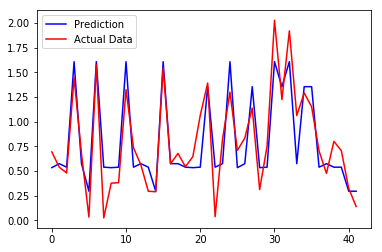

In [38]:
test_data = torch.FloatTensor(np.array(X_test_Cob))

x_test =  Variable(test_data)
y_pred_test = model(test_data)

y1_pred = y_pred_test.detach().numpy()
y1  = y_test_Cob

plt.plot(range(0,len(y1_pred)),y1_pred,c='b')
plt.plot(range(0,len(y1)),y1,c ='r')
plt.legend(['Prediction','Actual Data'])
print (np.std(y1_pred-y1))

0.19173594224847565


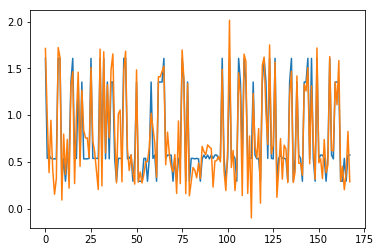

In [39]:
##train std deviation for the same data

train_data = torch.FloatTensor(np.array(X_train_Cob))

x_train =  Variable(train_data)
y_pred_train = model(train_data)

y1_pred = y_pred_train.detach().numpy()
y1  = y_train_Cob

plt.plot(range(0,len(y1_pred)),y1_pred)
plt.plot(range(0,len(y1)),y1)
print (np.std(y1_pred-y1))

In [56]:
###data preprocessing --- complete data -------no use 

print(len(CoS_filenames))

r,c,d=FV.shape


print (r)
print (FV.shape)
FV_reshape = FV.reshape((r*c,d))
for i in range(0,r*c):
    FV_reshape[:,i] = (FV_reshape[:,i] - np.mean(FV_reshape[:,i]))/np.std(FV_reshape[:,i])

print (FV_reshape.shape)

print (DGOH.T.shape)

###with test train split

X_train, X_test, y_train, y_test = train_test_split(FV_reshape.T, DGOH.T, test_size=0.33, random_state=42,shuffle= True)

210
3
(3, 18, 1470)
(54, 1470)
(1470, 1)


In [57]:
# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(X_train))
dg = np.array(y_train)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)


#######neural network


# Defining input size, hidden layer size, output size and batch size respectively
n_in, n_h1,n_h2,n_h3, n_out, batch_size = 54, 54,54,54, 1, 20



# Create a model
model = nn.Sequential(nn.Linear(n_in, n_h1),nn.Linear(n_h1, n_h2),
                     nn.Linear(n_h3, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Gradient Descent
for epoch in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()


epoch:  0  loss:  1.6335827112197876
epoch:  1000  loss:  0.08108830451965332
epoch:  2000  loss:  0.08680806308984756
epoch:  3000  loss:  0.07950840145349503
epoch:  4000  loss:  0.07711657136678696
epoch:  5000  loss:  0.07609106600284576
epoch:  6000  loss:  0.07978993654251099
epoch:  7000  loss:  0.07810556888580322
epoch:  8000  loss:  0.0765111893415451
epoch:  9000  loss:  0.07614091038703918


The standard deveation is:
0.27759522090819994


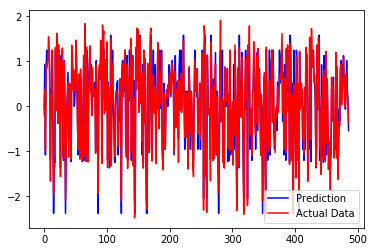

In [58]:
test_data = torch.FloatTensor(np.array(X_test))

x_test =  Variable(test_data)
y_pred_test = model(test_data)
y1_pred = y_pred_test.detach().numpy()
y1  = y_test

plt.plot(range(0,len(y1_pred)),y1_pred,c='b')
plt.plot(range(0,len(y1)),y1,c ='r')
plt.legend(['Prediction','Actual Data'])
print ('The standard deveation is:')
print (np.std(y1_pred-y1))

In [84]:
########Data preprocessing - Scaling gibbs free energy

In [66]:
r,c,d=FV.shape


FV_reshape = FV.reshape((r*c,d))
print (FV_reshape.shape)

FV_reshape = FV_reshape.T
#normalizing the the input x parameters 
for i in range(0,r*c):
    FV_reshape[:,i] = (FV_reshape[:,i] - np.mean(FV_reshape[:,i]))/np.std(FV_reshape[:,i])

#normalizing the Gibbs free energy values    
DGOH = (DGOH - np.mean(DGOH))/np.std(DGOH)

print (DGOH.T.shape)

###with test train split

X_train, X_test, y_train, y_test = train_test_split(FV_reshape, DGOH.T, test_size=0.33, random_state=42,shuffle= True)

print (X_train)

(54, 1470)
(1470, 1)
[[ 1.66102438 -0.22772473 -0.37166631 ... -0.31737502 -0.31100047
   0.19445158]
 [-0.61063236 -0.22772473 -0.37166631 ... -0.31737502 -0.31100047
   0.19445158]
 [-0.61063236 -0.22772473 -0.37166631 ... -0.31737502 -0.31100047
   0.19445158]
 ...
 [ 1.66102438 -0.22772473 -0.37166631 ... -0.31737502  3.69171088
   0.19445158]
 [-0.61063236 -0.22772473 -0.37166631 ...  5.12682713 -0.31100047
   0.19445158]
 [-0.61063236 -0.22772473 -0.37166631 ... -0.31737502 -0.31100047
   0.19445158]]


epoch:  0  loss:  1.0080686807632446


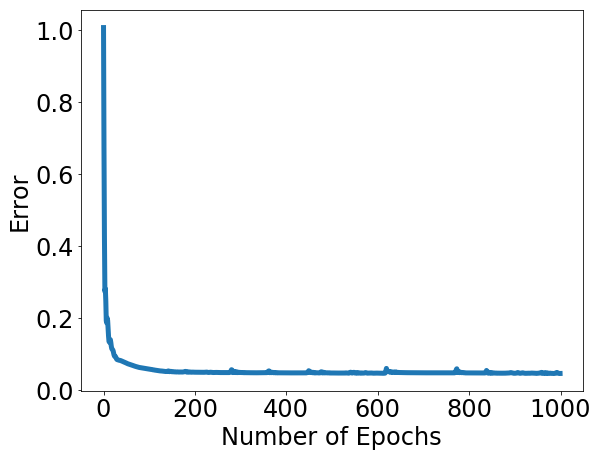

In [128]:
# importing all the required libraries, ensure that there are no errors that pop up
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F



train_data = torch.FloatTensor(np.array(X_train))
dg = np.array(y_train)

del_g =  torch.FloatTensor(dg)
x,y = Variable(train_data), Variable (del_g)


#######neural network


# Defining input size, hidden layer size, output size and batch size respectively
n_in, n_h1,n_h2,n_h3,n_h4, n_out, batch_size = 54, 54,54,54,54 ,1, 1000



# Create a model
model = nn.Sequential(nn.Linear(n_in, n_h1, bias = True),nn.ReLU(),nn.Linear(n_h1, n_h2, bias =False),
#                     nn.LeakyReLU(),nn.Linear(n_h3, n_h4, bias =False),
                     nn.ReLU(),nn.Linear(n_h3, n_out))


# Construct the loss function
criterion = torch.nn.MSELoss()

# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01,eps=1e-08, weight_decay=0)
loss1 = []
# Gradient Descent
for epoch in range(1000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)
    # Compute and print loss
    loss = criterion(y_pred, y)
    loss1.append(loss)
    if epoch%1000 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())
        

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

    
fig1 = plt.figure(figsize=(9,7))
plt.plot(range(0,len(loss1)),loss1, lw=5)
plt.ylabel('Error', fontsize=24)
plt.xlabel('Number of Epochs', fontsize=24)
plt.tick_params(labelsize=24)

plt.savefig('Neural Net convergence plot.png', dpi=1200) 
    
plt.show()
    
        

The standard deveation is:
0.22394087907615526
the MAE is
0.16920093850121465


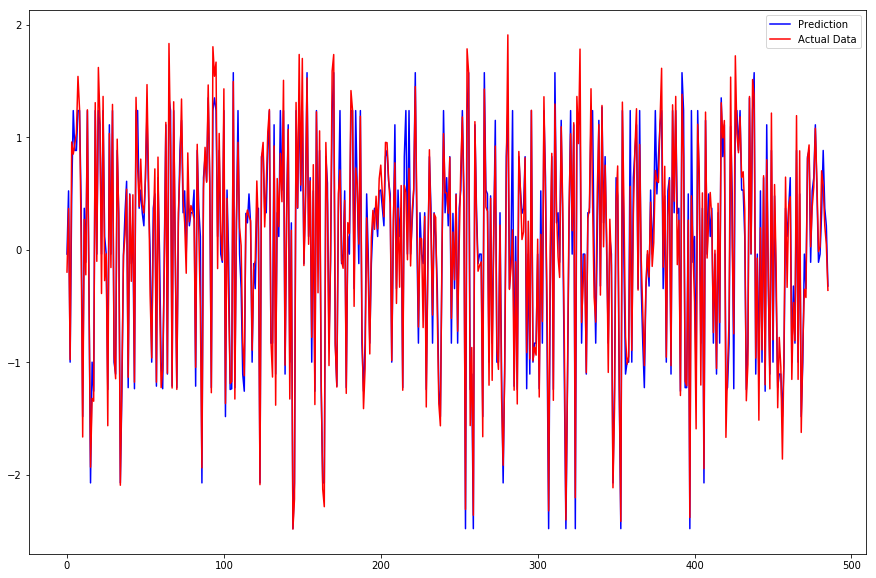

In [129]:
X_test = torch.FloatTensor(np.array(X_test))

test_data =  Variable(X_test)
y_pred_test = model(test_data)
y1_pred = y_pred_test.detach().numpy()
y1  = y_test

fig1 = plt.figure(figsize=(15,10))

plt.plot(range(0,len(y1_pred)),y1_pred,c='b')
plt.plot(range(0,len(y1)),y1,c ='r')
plt.legend(['Prediction','Actual Data'])
print ('The standard deveation is:')
print (np.std(y1_pred-y1))
print ('the MAE is')
print(np.mean(abs(y1_pred-y1)))

plt.show()






In [112]:
for parameter in model.parameters():
    print(np.shape (parameter))
    print (parameter)
    


torch.Size([54, 54])
Parameter containing:
tensor([[-0.0730, -0.2127,  0.0025,  ..., -0.2328, -0.1988,  0.4038],
        [-0.3090,  0.0494,  0.1386,  ...,  0.2692, -0.0378, -0.1581],
        [ 0.0006, -0.0265,  0.0009,  ..., -0.0604,  0.2294,  0.0972],
        ...,
        [ 0.0599, -0.2608,  0.1369,  ...,  0.0851,  0.0244,  0.0773],
        [ 0.3049, -0.2910, -0.3306,  ..., -0.1220,  0.0619,  0.1662],
        [-0.0555,  0.1131,  0.1569,  ...,  0.3043,  0.1683, -0.1004]],
       requires_grad=True)
torch.Size([54])
Parameter containing:
tensor([-0.0455, -0.7052, -0.8895, -0.2997, -0.3951, -0.3464, -0.4028, -0.4149,
        -0.4838, -0.5189, -0.5100, -0.0628,  0.1926,  0.1198, -0.9208, -1.3984,
        -0.0557,  0.1673, -0.0475, -0.3373, -0.0717, -0.6016, -0.5118, -0.7263,
        -0.6510,  0.0463, -0.5016, -0.0591,  0.0302, -0.6446, -0.3696, -1.6221,
         0.1791, -0.5882, -0.6230, -0.3411, -0.4664, -0.8019, -0.6954, -0.7711,
        -0.8600, -0.6472, -0.7658, -0.8481, -0.6795, -0.0

0.22394087907615526
0.16920093850121465
(486, 1)
486
60


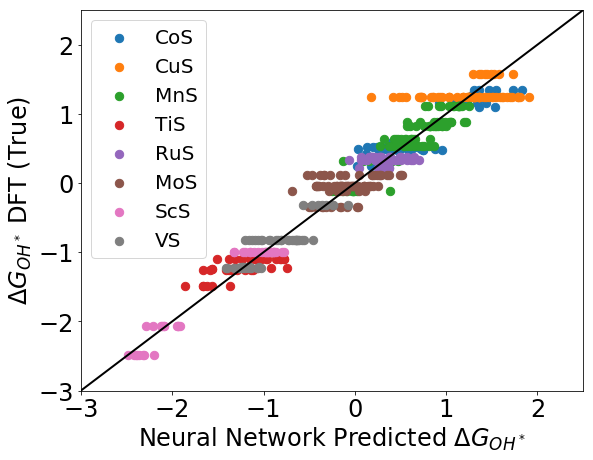

In [132]:
# Plot different classes in different colors
# Pred vec: y1_pred
# True vec: y1



## Constructing index vector where the index corresponds to the corresponding M-S class
print (np.std(y1_pred-y1))
print (np.mean(np.abs(y1_pred-y1)))

# len_vec=[210,180,240,210,150,120,180,180]

len_vec=[210,180,240,180,150,210,120,180]
len_vec_cum=np.cumsum(len_vec)
index=np.zeros((len(y1),1))
for i in range(len(y1)):
    pos=(list(DGOH.T)).index(y1[i])
    for j in range(len(len_vec_cum)):
        if pos<len_vec_cum[j]:
            index[i]=j
            break
# Index vector construction done
# Plotting different colors starts here
print(index.shape)
print(len(y1))
print (list(index).count(0))


y1_CoS=[]
y1_CuS=[]
y1_MnS=[]
y1_TiS=[]
y1_RuS=[]
y1_MoS=[]
y1_ScS=[]
y1_VS=[]

yp_CoS=[]
yp_CuS=[]
yp_MnS=[]
yp_TiS=[]
yp_RuS=[]
yp_MoS=[]
yp_ScS=[]
yp_VS=[]
yp=y1_pred

for i in range(len(y1)):
    if index[i]==0:
        y1_CoS.append(y1[i])
        yp_CoS.append(yp[i])
    if index[i]==1:
        y1_CuS.append(y1[i])
        yp_CuS.append(yp[i])
    if index[i]==2:
        y1_MnS.append(y1[i])
        yp_MnS.append(yp[i])
    if index[i]==3:
        y1_TiS.append(y1[i])
        yp_TiS.append(yp[i])
    if index[i]==4:
        y1_RuS.append(y1[i])
        yp_RuS.append(yp[i])
    if index[i]==5:
        y1_MoS.append(y1[i])
        yp_MoS.append(yp[i])
    if index[i]==6:
        y1_ScS.append(y1[i])
        yp_ScS.append(yp[i])
    if index[i]==7:
        y1_VS.append(y1[i])
        yp_VS.append(yp[i])
        
# plt.scatter(y1_CoS, yp_CoS, c='b', s=70,label='CoS')
# plt.scatter(y1_CuS, yp_CuS, c='g', s=70,label='CuS')
# plt.scatter(y1_MnS, yp_MnS, c='r', s=70,label='MnS')
# plt.scatter(y1_TiS, yp_TiS, c='c', s=70,label='TiS')
# plt.scatter(y1_RuS, yp_RuS, c='m', s=70,label='RuS')
# plt.scatter(y1_MoS, yp_MoS, c='y', s=70,label='MoS')
# plt.scatter(y1_ScS, yp_ScS, c='k', s=70,label='ScS')
# plt.scatter(y1_VS, yp_VS, c='m', s=70,label='VS')

fig1 = plt.figure(figsize=(9,7))

plt.ylabel('$\Delta G_{OH^*}$ DFT (True)', fontsize=24)
plt.xlabel('Neural Network Predicted $\Delta G_{OH^*}$', fontsize=24)
plt.tick_params(labelsize=24)

plt.scatter( y1_CoS,yp_CoS,s=70,label='CoS')
plt.scatter( y1_CuS,yp_CuS, s=70,label='CuS')
plt.scatter( y1_MnS,yp_MnS, s=70,label='MnS')
plt.scatter(y1_TiS, yp_TiS,  s=70,label='TiS')
plt.scatter(  y1_RuS, yp_RuS,s=70,label='RuS')
plt.scatter(y1_MoS,yp_MoS,  s=70,label='MoS')
plt.scatter( y1_ScS, yp_ScS, s=70,label='ScS')
plt.scatter(y1_VS,yp_VS,   s=70,label='VS')
plt.legend(prop={'size':20})


        
start=-3
end=2.5
plt.xlim([start,end])
plt.ylim([start,end])
p1=[start,end]
p2=[start,end]
plt.plot(p1,p2,c='black', lw='2', ls='-')
#plt.legend(loc='upper right', frameon=False, prop={'weight':'bold','size':20})
plt.ylabel('$\Delta G_{OH^*}$ DFT (True)', fontsize=24)
plt.xlabel('Neural Network Predicted $\Delta G_{OH^*}$', fontsize=24)
plt.tick_params(labelsize=24)

plt.savefig('Neural Net_plot.png', dpi=1200) 
        
        


    
# Co Cu Mn, Ti, Ru, Mo, Sc, V


# 210,180,240,210,150,120,180,180
# Co,Cu, Mn, Mo, Ru ,Sc, Ti, V

In [106]:
#using a more complex neural network 

In [136]:
r,c,d=FV.shape


FV_reshape = FV.reshape((r*c,d))


#normalizing the the input x parameters 
for i in range(0,r*c):
    FV_reshape[:,i] = (FV_reshape[:,i] - np.mean(FV_reshape[:,i]))/np.std(FV_reshape[:,i])

#normalizing the Gibbs free energy values    
for j in range(0,len(DGOH)):
    DGOH[:] = (DGOH[:] - np.mean(DGOH[:]))/np.std(DGOH[:])

print (DGOH.T.shape)

###with test train split

X_train, X_test, y_train, y_test = train_test_split(FV_reshape.T, DGOH.T, test_size=0.33, random_state=42,shuffle= True)


(1470, 1)


In [137]:
r,c,d=FV1.shape


FV1_reshape = FV1.reshape((r*c,d))
r,c,d=FV2.shape
FV2_reshape = FV2.reshape((r*c,d))
r,c,d=FV3.shape
FV3_reshape = FV3.reshape((r*c,d))
r,c,d=FV4.shape
FV4_reshape = FV4.reshape((r*c,d))
r,c,d=FV5.shape
FV5_reshape = FV5.reshape((r*c,d))
r,c,d=FV6.shape
FV6_reshape = FV6.reshape((r*c,d))
r,c,d=FV7.shape
FV7_reshape = FV7.reshape((r*c,d))
r,c,d=FV8.shape
FV8_reshape = FV8.reshape((r*c,d))


###with test train split

X_train_Cob, X_test_Cob, y_train_Cob, y_test_Cob = train_test_split(FV1_reshape.T, vec_Co_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Cub, X_test_Cub, y_train_Cub, y_test_Cub = train_test_split(FV2_reshape.T, vec_Cu_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Mn, X_test_Mn, y_train_Mn, y_test_Mn = train_test_split(FV3_reshape.T, vec_Mn_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Ti, X_test_Ti, y_train_Ti, y_test_Ti = train_test_split(FV4_reshape.T, vec_Ti_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Ru, X_test_Ru, y_train_Ru, y_test_Ru = train_test_split(FV5_reshape.T, vec_Ru_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Mo, X_test_Mo, y_train_Mo, y_test_Mo = train_test_split(FV6_reshape.T, vec_Mo_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_Sc, X_test_Sc, y_train_Sc, y_test_Sc = train_test_split(FV7_reshape.T, vec_Sc_reshape, test_size=0.2, random_state=42,shuffle=True)
X_train_V, X_test_V, y_train_V, y_test_V = train_test_split(FV8_reshape.T, vec_V_reshape, test_size=0.2, random_state=42,shuffle=True)



print (X_train_Cob.shape)

(168, 54)


In [138]:
from sklearn import neighbors

#fit model

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_Cob, y_train_Cob)
y_pred_Cob = knn.predict(X_test_Cob)
y1_Cob  = y_test_Cob

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_Cub, y_train_Cub)
y_pred_Cub = knn.predict(X_test_Cub)
y1_Cub  = y_test_Cub

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_Mn, y_train_Mn)
y_pred_Mn = knn.predict(X_test_Mn)
y1_Mn  = y_test_Mn

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_Mo, y_train_Mo)
y_pred_Mo = knn.predict(X_test_Mo)
y1_Mo  = y_test_Mo

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_Ru, y_train_Ru)
y_pred_Ru = knn.predict(X_test_Ru)
y1_Ru  = y_test_Ru

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_Sc, y_train_Sc)
y_pred_Sc = knn.predict(X_test_Sc)
y1_Sc  = y_test_Sc

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_Ti, y_train_Ti)
y_pred_Ti = knn.predict(X_test_Ti)
y1_Ti  = y_test_Ti

knn = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train_V, y_train_V)
y_pred_V = knn.predict(X_test_V)
y1_V  = y_test_V


The MAE and RSME of CoS is 0.19459442997661516 and 0.24087986188837276
The MAE and RSME of CuS is 0.3747931232657056 and 0.48398124753484545
The MAE and RSME of MnS is 0.13872879476056846 and 0.17143006651355933
The MAE and RSME of TiS is 0.18293865617869587 and 0.20360621688655858
The MAE and RSME of RuS is 0.1757144034688437 and 0.20279501886973522
The MAE and RSME of MoS is 0.21291576094630868 and 0.26599342116015257
The MAE and RSME of ScS is 0.09883232925747161 and 0.1096888151517991
The MAE and RSME of VS is 0.11815274300926452 and 0.1542356505005148
Cross Validation = [0.95421166 0.94130183 0.94344556 0.94083167 0.92388851 0.96592577
 0.9267478  0.95739259 0.9494072  0.92141733]
The MAE of the data is 0.1896246972171656
The RMSE of the data is 0.25815575214837105


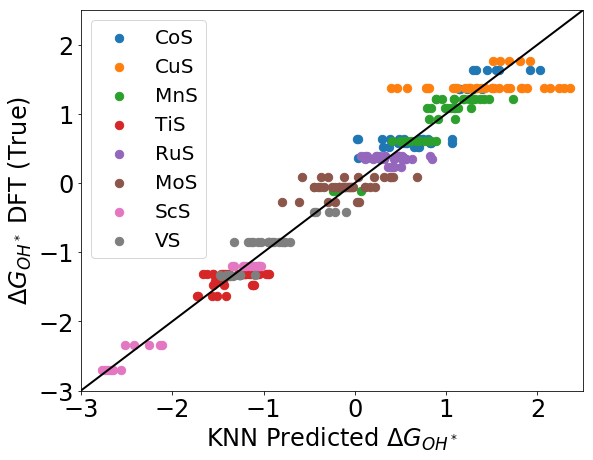

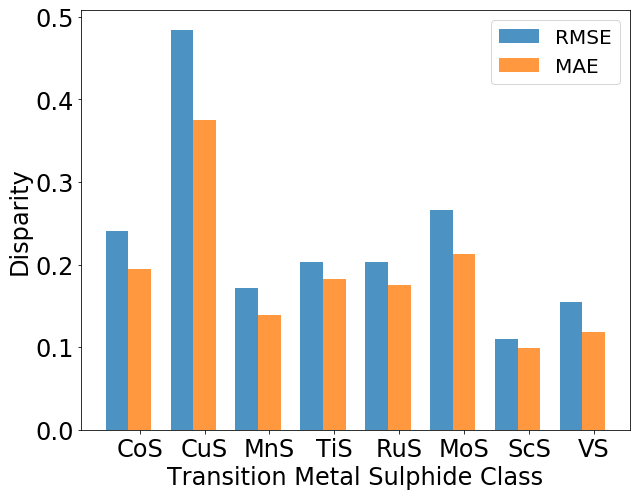

In [142]:
#plt.plot(range(0,len(y_pred_test)),y_pred_test)
#plt.plot(range(0,len(y1)),y1)
print ('The MAE and RSME of CoS is {0} and {1}'.format(np.mean(abs(y1_Cob-y_pred_Cob)), np.std(y1_Cob-y_pred_Cob)))
print ('The MAE and RSME of CuS is {0} and {1}'.format(np.mean(abs(y1_Cub-y_pred_Cub)), np.std(y1_Cub-y_pred_Cub)))
print ('The MAE and RSME of MnS is {0} and {1}'.format(np.mean(abs(y1_Mn-y_pred_Mn)), np.std(y1_Mn-y_pred_Mn)))
print ('The MAE and RSME of TiS is {0} and {1}'.format(np.mean(abs(y1_Ti-y_pred_Ti)), np.std(y1_Ti-y_pred_Ti)))
print ('The MAE and RSME of RuS is {0} and {1}'.format(np.mean(abs(y1_Ru-y_pred_Ru)), np.std(y1_Ru-y_pred_Ru)))
print ('The MAE and RSME of MoS is {0} and {1}'.format(np.mean(abs(y1_Mo-y_pred_Mo)), np.std(y1_Mo-y_pred_Mo)))
print ('The MAE and RSME of ScS is {0} and {1}'.format(np.mean(abs(y1_Sc-y_pred_Sc)), np.std(y1_Sc-y_pred_Sc)))
print ('The MAE and RSME of VS is {0} and {1}'.format(np.mean(abs(y1_V-y_pred_V)), np.std(y1_V-y_pred_V)))



# print (np.std(y_pred_test-y1))


fig1 = plt.figure(figsize=(9,7))
plt.ylabel('$\Delta G_{OH^*}$ DFT (True)', fontsize=24)
plt.xlabel('Neural Network Predicted $\Delta G_{OH^*}$', fontsize=24)
plt.tick_params(labelsize=24)

plt.scatter( y1_Cob,y_pred_Cob, s=70,label='CoS')
plt.scatter( y1_Cub,y_pred_Cub, s=70,label='CuS')
plt.scatter( y1_Mn,y_pred_Mn, s=70,label='MnS')
plt.scatter( y1_Ti,y_pred_Ti, s=70,label='TiS')
plt.scatter( y1_Ru,y_pred_Ru, s=70,label='RuS')
plt.scatter( y1_Mo,y_pred_Mo, s=70,label='MoS')
plt.scatter( y1_Sc,y_pred_Sc, s=70,label='ScS')
plt.scatter( y1_V,y_pred_V, s=70,label='VS')
plt.legend()
plt.legend(prop={'size':20})


start=-3
end=2.5
plt.xlim([start,end])
plt.ylim([start,end])
p1=[start,end]
p2=[start,end]
plt.plot(p1,p2,c='black', lw='2', ls='-')
#plt.legend(loc='upper right', frameon=False, prop={'weight':'bold','size':20})
plt.ylabel('$\Delta G_{OH^*}$ DFT (True)', fontsize=24)
plt.xlabel('KNN Predicted $\Delta G_{OH^*}$', fontsize=24)
plt.tick_params(labelsize=24)


#plot of std with number of neighbors (inset in other plot)

from sklearn.model_selection import cross_val_score
CV = cross_val_score(knn, X_train, y_train, cv=10)
print('Cross Validation =',CV)
plt.savefig('KNN individual compound Accuracy plot.png', dpi=1200) 

import matplotlib.pyplot as plt
 
    
    
Co_RMSE = np.std(y1_Cob-y_pred_Cob)
CuS_RMSE = np.std(y1_Cub-y_pred_Cub)
Mn_RMSE = np.std(y1_Mn-y_pred_Mn)
Ti_RMSE =  np.std(y1_Ti-y_pred_Ti)
Ru_RMSE =  np.std(y1_Ru-y_pred_Ru)
Mo_RMSE = np.std(y1_Mo-y_pred_Mo)
Sc_RMSE = np.std(y1_Sc-y_pred_Sc)
V_RMSE = np.std(y1_V-y_pred_V)


Co_MAE = np.mean(abs(y1_Cob-y_pred_Cob))
CuS_MAE = np.mean(abs(y1_Cub-y_pred_Cub))
Mn_MAE = np.mean(abs(y1_Mn-y_pred_Mn))
Ti_MAE =  np.mean(abs(y1_Ti-y_pred_Ti))
Ru_MAE =  np.mean(abs(y1_Ru-y_pred_Ru))
Mo_MAE = np.mean(abs(y1_Mo-y_pred_Mo))
Sc_MAE = np.mean(abs(y1_Sc-y_pred_Sc))
V_MAE = np.mean(abs(y1_V-y_pred_V))

y_pred_1 = np.vstack((y_pred_Cob, y_pred_Cub, y_pred_Mn, y_pred_Ti, y_pred_Mo, y_pred_Ru, y_pred_Sc,  y_pred_V))
y_pred_1= np.ravel(y_pred_1)
y1_1 = np.vstack((y1_Cob, y1_Cub, y1_Mn, y1_Ti, y1_Mo, y1_Ru, y1_Sc,  y1_V))
y1_1= np.ravel(y1_1)


Overall_MAE = np.mean(abs(y1_1-y_pred_1))
Overall_RMSE = np.std(y1_1-y_pred_1)   

print ('The MAE of the data is {0}'.format(Overall_MAE))
print ('The RMSE of the data is {0}'.format(Overall_RMSE))
# data to plot
n_groups = 8
RMSE = (Co_RMSE, CuS_RMSE, Mn_RMSE, Ti_RMSE, Ru_RMSE, Mo_RMSE, Sc_RMSE, V_RMSE)
MAE = (Co_MAE, CuS_MAE, Mn_MAE, Ti_MAE, Ru_MAE, Mo_MAE, Sc_MAE, V_MAE)
 
# create plot
fig, ax = plt.subplots(figsize=(9,7))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, RMSE, bar_width,
                 alpha=opacity,
                   label='RMSE')
 
rects2 = plt.bar(index + bar_width, MAE, bar_width,
                 alpha=opacity,

                 label='MAE')
 

plt.xlabel('Transition Metal Sulphide Class', fontsize=24)
plt.ylabel('Disparity', fontsize=24)



plt.xticks(index + bar_width, ('CoS', 'CuS', 'MnS', 'TiS','RuS','MoS','ScS','VS'))
plt.legend(prop={'size':20})
plt.tick_params(labelsize=24)

 
plt.tight_layout()

plt.savefig('RMSE and MAE plot for various sulphides.png', dpi=1200) 


In [440]:
MAE = np.zeros(100)
STD = np.zeros(100)
num_neigh = np.zeros(100)

for i in range(100):
    knn = neighbors.KNeighborsRegressor(n_neighbors = i+1)
    knn.fit(X_train_new, y_train_new)
    y_pred_test = knn.predict(X_test_new)
    y1  = y_test_new
    
    MAE[i] = np.mean(abs(y_pred_test-y1))
    STD[i] = np.std(y_pred_test-y1)
    num_neigh[i] = i+1
#end for loop

NameError: name 'X_train_new' is not defined

TypeError: can't multiply sequence by non-int of type 'float'

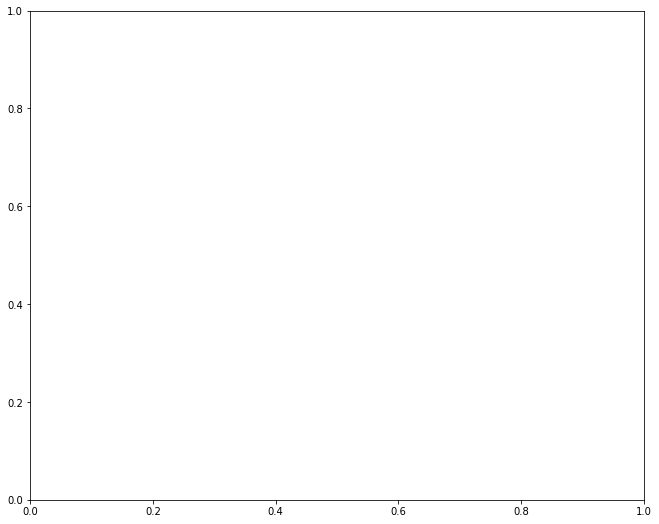

In [404]:
fig1 = plt.figure(figsize=(11,9))
plt.plot(num_neigh,MAE,c='black', lw='2', ls='--', marker='o')
start=-0.5
end=30.5
#plt.xlim([start,end])
#plt.ylim([0.16,0.241])

#plt.legend(loc='upper right', frameon=False, prop={'weight':'bold','size':20})
plt.ylabel('Mean Absolute Error', fontsize=28)
plt.xlabel('Number of Nearest Neighbors', fontsize=28)
plt.tick_params(labelsize=24)

plt.savefig('KNN_MAE_Co.png', dpi=1400)

fig2 = plt.figure(figsize=(9,7))
plt.plot(num_neigh,STD,c='black', lw='2', ls='--', marker='o')
start=-0.5
end=30.5
#plt.xlim([start,end])
#plt.ylim([start,end])

#plt.legend(loc='upper right', frameon=False, prop={'weight':'bold','size':20})
plt.ylabel('Standard Deviation', fontsize=24)
plt.xlabel('Number of Nearest Neighbors', fontsize=24)
plt.tick_params(labelsize=24)

In [144]:
r,c,d=FV.shape


FV_reshape = FV.reshape((r*c,d))
print (FV_reshape.shape)

FV_reshape = FV_reshape.T
#normalizing the the input x parameters 
for i in range(0,r*c):
    FV_reshape[:,i] = (FV_reshape[:,i] - np.mean(FV_reshape[:,i]))/np.std(FV_reshape[:,i])

#normalizing the Gibbs free energy values    
DGOH = (DGOH - np.mean(DGOH))/np.std(DGOH)

print (DGOH.T.shape)

###with test train split

X_train, X_test, y_train, y_test = train_test_split(FV_reshape, DGOH.T, test_size=0.33, random_state=42,shuffle= True)




(54, 1470)
(1470, 1)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: 'continuous'